In [17]:
pip install tensorflowjs

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from PIL import Image
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: []


In [19]:
print("\n=== Menyiapkan Custom Callback ===", flush=True)
class CustomAccuracyCallback(tf.keras.callbacks.Callback):
    """Custom callback untuk stop training ketika akurasi target tercapai"""
    def __init__(self, target_accuracy=0.95, target_val_accuracy=0.95):
        super().__init__()
        self.target_accuracy = target_accuracy
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get("accuracy", 0)
        val_accuracy = logs.get("val_accuracy", 0)

        if accuracy > self.target_accuracy and val_accuracy > self.target_val_accuracy:
            print(f"\nTARGET TERCAPAI!", flush=True)
            print(f"   Accuracy: {accuracy:.4f} (>{self.target_accuracy})", flush=True)
            print(f"   Val Accuracy: {val_accuracy:.4f} (>{self.target_val_accuracy})", flush=True)
            print("   Menghentikan training...", flush=True)
            self.model.stop_training = True

print("Custom callback siap.\n", flush=True)


=== Menyiapkan Custom Callback ===
Custom callback siap.



In [20]:
dataset_path = '/content/drive/MyDrive/animal-image-classification-dataset/Animals'

print("\n" + "="*60, flush=True)
print("CHECKING DATASET", flush=True)
print("="*60, flush=True)

if not os.path.exists(dataset_path):
    print("ERROR: Path dataset tidak ditemukan!", flush=True)
else:
    print("Dataset ditemukan!", flush=True)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Total Kelas: {len(classes)}", flush=True)
    print(f"Nama Kelas: {classes}", flush=True)


CHECKING DATASET
Dataset ditemukan!
Total Kelas: 3
Nama Kelas: ['snakes', 'cats', 'dogs']


In [21]:
print("\n" + "="*60, flush=True)
print("EKSPLORASI & ANALISIS DATASET", flush=True)
print("="*60, flush=True)

def analyze_dataset(directory):
    """Analisis lengkap dataset termasuk resolusi dan kualitas"""
    class_distribution = {}
    resolution_stats = {}
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_distribution[class_name] = len(images)
        total_images += len(images)

        # Sample beberapa gambar untuk cek resolusi
        resolutions = []
        for img_file in images[:10]:
            try:
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    resolutions.append(img.size)
            except:
                pass

        if resolutions:
            resolution_stats[class_name] = resolutions

    # Print statistics
    print(f"Total Images: {total_images}", flush=True)
    print(f"Total Classes: {len(class_distribution)}", flush=True)
    print("\nClass Distribution:", flush=True)
    for class_name, count in sorted(class_distribution.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_images) * 100 if total_images > 0 else 0
        print(f"  {class_name}: {count} images ({percentage:.1f}%)", flush=True)

    # Check for imbalance
    counts = list(class_distribution.values()) if class_distribution else [0]
    max_count = max(counts) if counts else 0
    min_count = min(counts) if counts else 0
    imbalance_ratio = max_count / min_count if min_count > 0 else 0

    print(f"\nDataset Balance:", flush=True)
    print(f"  Max images per class: {max_count}", flush=True)
    print(f"  Min images per class: {min_count}", flush=True)
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}x", flush=True)

    if imbalance_ratio > 2:
        print("Dataset imbalanced! Consider using class_weights or data augmentation", flush=True)
    else:
        print("Dataset relatively balanced", flush=True)

    return class_distribution, total_images, imbalance_ratio

print("Mulai analisis dataset...", flush=True)
class_dist, total_imgs, imbalance_ratio = analyze_dataset(dataset_path)
print("Analisis dataset selesai.", flush=True)
print("="*60, flush=True)


EKSPLORASI & ANALISIS DATASET
Mulai analisis dataset...
Total Images: 3000
Total Classes: 3

Class Distribution:
  snakes: 1000 images (33.3%)
  cats: 1000 images (33.3%)
  dogs: 1000 images (33.3%)

Dataset Balance:
  Max images per class: 1000
  Min images per class: 1000
  Imbalance ratio: 1.00x
Dataset relatively balanced
Analisis dataset selesai.


In [22]:
print("\n" + "="*60, flush=True)
print("SPLIT DATASET (70% Train, 15% Val, 15% Test)", flush=True)
print("="*60, flush=True)

base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(train_dir):
    print(" Dataset sudah pernah di-split", flush=True)
else:
    print("Memulai split dataset...", flush=True)

    for directory in [train_dir, validation_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        np.random.seed(42)
        np.random.shuffle(images)

        total = len(images)
        train_size = int(0.7 * total)
        val_size = int(0.15 * total)

        train_imgs = images[:train_size]
        val_imgs = images[train_size:train_size + val_size]
        test_imgs = images[train_size + val_size:]

        for img in train_imgs:
            shutil.copy2(os.path.join(class_path, img),
                        os.path.join(train_dir, class_name, img))

        for img in val_imgs:
            shutil.copy2(os.path.join(class_path, img),
                        os.path.join(validation_dir, class_name, img))

        for img in test_imgs:
            shutil.copy2(os.path.join(class_path, img),
                        os.path.join(test_dir, class_name, img))

        print(f"  {class_name}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}", flush=True)

    print("✓ Split selesai!", flush=True)

print("="*60, flush=True)



SPLIT DATASET (70% Train, 15% Val, 15% Test)
⚠️ Dataset sudah pernah di-split


In [23]:
print("\n" + "="*60, flush=True)
print("SETUP DATA PREPROCESSING & AUGMENTATION", flush=True)
print("="*60, flush=True)

IMG_SIZE = 224  # Ukuran lebih besar untuk transfer learning
BATCH_SIZE = 32

# Data Augmentation yang lebih aggressive untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Hanya rescaling untuk validation dan test
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Membuat image generators...", flush=True)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

print(f"✓ Train samples: {train_generator.samples}", flush=True)
print(f"✓ Validation samples: {validation_generator.samples}", flush=True)
print(f"✓ Test samples: {test_generator.samples}", flush=True)
print(f"✓ Number of classes: {num_classes}", flush=True)
print(f"✓ Image size: {IMG_SIZE}x{IMG_SIZE}", flush=True)
print("="*60, flush=True)


SETUP DATA PREPROCESSING & AUGMENTATION
Membuat image generators...
Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
✓ Train samples: 2100
✓ Validation samples: 450
✓ Test samples: 450
✓ Number of classes: 3
✓ Image size: 224x224



VISUALISASI SAMPLE DATA


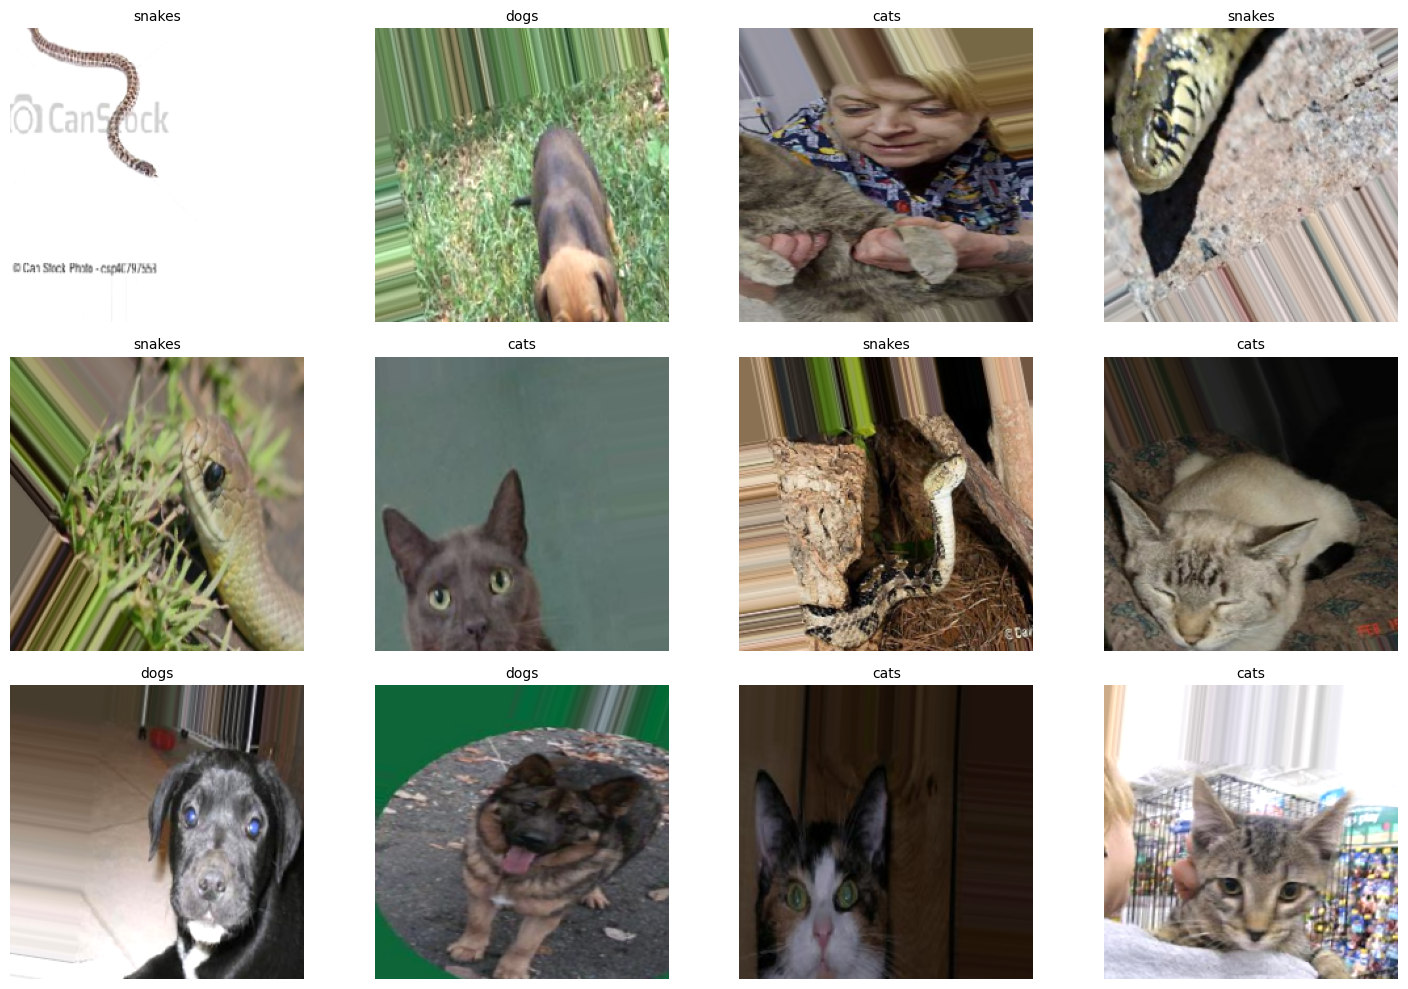

✓ Sample saved to 'sample_images.png'


In [24]:
print("\n" + "="*60, flush=True)
print("VISUALISASI SAMPLE DATA", flush=True)
print("="*60, flush=True)

plt.figure(figsize=(15, 10))
images, labels = next(train_generator)

for i in range(min(12, len(images))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(class_labels[class_idx], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample saved to 'sample_images.png'", flush=True)
print("="*60, flush=True)

In [29]:
print("="*60)
print("MEMBANGUN MODEL HYBRID")
print("="*60)
print("Model Sequential dengan Transfer Learning + Custom CNN")
print("="*60)

# Load MobileNetV2 base (frozen)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

print(f"✓ MobileNetV2 loaded (frozen)")
print(f"✓ Base model layers: {len(base_model.layers)}")

# Build Hybrid Model dalam Sequential
# Transfer Learning + Custom Conv2D & Pooling
model = models.Sequential([
    # INPUT
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # TRANSFER LEARNING PART
    base_model,

    # ============= CUSTOM CONV2D & POOLING (KRITERIA!) =============
    # Custom Convolutional Block 1
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='custom_conv2d_1'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='custom_maxpool_1'),
    layers.Dropout(0.3),

    # Custom Convolutional Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='custom_conv2d_2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='custom_maxpool_2'),
    layers.Dropout(0.3),

    # Custom Convolutional Block 3
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='custom_conv2d_3'),
    layers.BatchNormalization(),
    #layers.MaxPooling2D((2, 2), name='custom_maxpool_3'), # Removed this layer
    layers.Dropout(0.3),
    # ================================================================

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')

], name='Hybrid_Animal_Classification')

print("\n✓ Model created successfully!")
print("="*60)
print("ARSITEKTUR MODEL:")
print("  1. MobileNetV2 (Transfer Learning) - FROZEN")
print("  2. Custom Conv2D Layer 1 (256 filters)")
print("  3. Custom MaxPooling Layer 1")
print("  4. Custom Conv2D Layer 2 (128 filters)")
print("  5. Custom MaxPooling Layer 2")
print("  6. Custom Conv2D Layer 3 (64 filters)")
#print("  7. Custom MaxPooling Layer 3") # Removed this from description
print("  7. Dense Layers (512 -> 256 -> num_classes)") # Updated numbering
print("="*60)
print("\n✅ KRITERIA TERPENUHI:")
print("  ✓ Model Sequential")
print("  ✓ Conv2D layers (3 custom layers)")
print("  ✓ MaxPooling layers (2 custom layers)") # Updated count
print("  ✓ Transfer Learning tetap digunakan")
print("="*60)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled!")

# Show summary
model.summary()

total_params = model.count_params()
print(f"\n✓ Total Parameters: {total_params:,}")

MEMBANGUN MODEL HYBRID
Model Sequential dengan Transfer Learning + Custom CNN
✓ MobileNetV2 loaded (frozen)
✓ Base model layers: 154

✓ Model created successfully!
ARSITEKTUR MODEL:
  1. MobileNetV2 (Transfer Learning) - FROZEN
  2. Custom Conv2D Layer 1 (256 filters)
  3. Custom MaxPooling Layer 1
  4. Custom Conv2D Layer 2 (128 filters)
  5. Custom MaxPooling Layer 2
  6. Custom Conv2D Layer 3 (64 filters)
  7. Dense Layers (512 -> 256 -> num_classes)

✅ KRITERIA TERPENUHI:
  ✓ Model Sequential
  ✓ Conv2D layers (3 custom layers)
  ✓ MaxPooling layers (2 custom layers)
  ✓ Transfer Learning tetap digunakan

✓ Model compiled!


Model: "Hybrid_Animal_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_1 (Conv2D)        │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_maxpool_1 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_2 (Conv2D)        │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_maxpool_2 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_3 (Conv2D)        │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,746,435 (21.92 MB)

 Trainable params: 3,486,019 (13.30 MB)

 Non-trainable params: 2,260,416 (8.62 MB)


✓ Total Parameters: 5,746,435


In [30]:
from sklearn.utils import compute_class_weight

if imbalance_ratio > 2:
    print("="*60)
    print("CALCULATING CLASS WEIGHTS")
    print("="*60)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weight_dict = dict(enumerate(class_weights))

    print("Class weights:")
    for idx, weight in class_weight_dict.items():
        print(f"  {class_labels[idx]}: {weight:.2f}")

    print("="*60)
else:
    class_weight_dict = None
    print("✓ Dataset balanced - class weights not needed")

✓ Dataset balanced - class weights not needed


In [31]:
callbacks = [
    # Custom callback - stop at 85%
    CustomAccuracyCallback(target_accuracy=0.85, target_val_accuracy=0.85),

    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Model checkpoint
    ModelCheckpoint(
        'best_model_phase1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("="*60)
print("CALLBACKS CONFIGURED")
print("="*60)
print("  1. CustomAccuracyCallback (target: 85%)")
print("  2. EarlyStopping (patience: 15)")
print("  3. ModelCheckpoint (save best model)")
print("  4. ReduceLROnPlateau (adaptive LR)")
print("="*60)


CALLBACKS CONFIGURED
  1. CustomAccuracyCallback (target: 85%)
  2. EarlyStopping (patience: 15)
  3. ModelCheckpoint (save best model)
  4. ReduceLROnPlateau (adaptive LR)


In [32]:
print("="*60)
print("PHASE 1: TRAINING (TRANSFER LEARNING)")
print("="*60)
print("MobileNetV2: FROZEN")
print("Custom Layers: TRAINABLE")
print("="*60)

EPOCHS_PHASE1 = 40

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n" + "="*60)
print("✓ PHASE 1 TRAINING SELESAI!")
print("="*60)


PHASE 1: TRAINING (TRANSFER LEARNING)
MobileNetV2: FROZEN
Custom Layers: TRAINABLE
Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6227 - loss: 1.0226

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.95778, saving model to best_model_phase1.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.6247 - loss: 1.0171 - val_accuracy: 0.9578 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8918 - loss: 0.3332
TARGET TERCAPAI!
   Accuracy: 0.8995 (>0.85)
   Val Accuracy: 0.9733 (>0.85)
   Menghentikan training...

Epoch 2: val_accuracy improved from 0.95778 to 0.97333, saving model to best_model_phase1.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8919 - loss: 0.3328 - val_accuracy: 0.9733 - val_loss: 0.0848 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.

✓ PHASE 1 TRAINING SELESAI!


In [33]:
print("="*60)
print("EVALUASI PHASE 1")
print("="*60)

# Evaluasi menggunakan model.evaluate()
train_loss_p1, train_acc_p1 = model.evaluate(train_generator, verbose=1)
val_loss_p1, val_acc_p1 = model.evaluate(validation_generator, verbose=1)

print("\nPhase 1 Results:")
print(f"  Train Accuracy: {train_acc_p1*100:.2f}%")
print(f"  Train Loss: {train_loss_p1:.4f}")
print(f"  Val Accuracy: {val_acc_p1*100:.2f}%")
print(f"  Val Loss: {val_loss_p1:.4f}")
print("="*60)

EVALUASI PHASE 1
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9193 - loss: 0.1914
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9738 - loss: 0.0812

Phase 1 Results:
  Train Accuracy: 92.52%
  Train Loss: 0.1734
  Val Accuracy: 97.33%
  Val Loss: 0.0848


In [34]:
print("="*60)
print("PHASE 2: FINE-TUNING")
print("="*60)

# Unfreeze top layers dari base model
base_model.trainable = True

# Freeze hanya layer awal
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✓ Total base model layers: {len(base_model.layers)}")
print(f"✓ Trainable layers: {len([l for l in base_model.layers if l.trainable])}")
print(f"✓ Frozen layers: {fine_tune_at}")

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model recompiled (LR: 0.0001)")

# Setup callbacks phase 2
callbacks_phase2 = [
    CustomAccuracyCallback(target_accuracy=0.95, target_val_accuracy=0.95),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_phase2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("✓ Callbacks updated for phase 2")
print("="*60)

EPOCHS_PHASE2 = 30

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n" + "="*60)
print("✓ PHASE 2 FINE-TUNING SELESAI!")
print("="*60)

PHASE 2: FINE-TUNING
✓ Total base model layers: 154
✓ Trainable layers: 54
✓ Frozen layers: 100
✓ Model recompiled (LR: 0.0001)
✓ Callbacks updated for phase 2
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8791 - loss: 0.3520
Epoch 1: val_accuracy improved from -inf to 0.96889, saving model to best_model_phase2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8794 - loss: 0.3510 - val_accuracy: 0.9689 - val_loss: 0.1008 - learning_rate: 1.0000e-04
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9048 - loss: 0.2496
Epoch 2: val_accuracy improved from 0.96889 to 0.97778, saving model to best_model_phase2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.9049 - loss: 0.2493 - val_accuracy: 0.9778 - val_loss: 0.0808 - learning_rate: 1.0000e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9389 - loss: 0.1857
Epoch 3: val_accuracy did not improve from 0.97778
66/66 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.9388 - lo

In [35]:
print("="*60)
print("EVALUASI MODEL FINAL")
print("="*60)

# Evaluasi menggunakan model.evaluate() - KRITERIA!
print("\nEvaluating Training Set...")
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)

print("\nEvaluating Validation Set...")
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)

print("\nEvaluating Test Set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "="*60)
print("HASIL EVALUASI FINAL:")
print("="*60)
print(f"Training Set:")
print(f"  Accuracy: {train_accuracy*100:.2f}%")
print(f"  Loss: {train_loss:.4f}")

print(f"\nValidation Set:")
print(f"  Accuracy: {val_accuracy*100:.2f}%")
print(f"  Loss: {val_loss:.4f}")

print(f"\nTest Set:")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss: {test_loss:.4f}")

print("\n" + "-"*60)
if train_accuracy >= 0.85 and test_accuracy >= 0.85:
    print(f"   ✓ Train Accuracy: {train_accuracy*100:.2f}% (≥85%)")
    print(f"   ✓ Test Accuracy: {test_accuracy*100:.2f}% (≥85%)")
else:
    print("Akurasi belum mencapai 85%")

if train_accuracy >= 0.95 and val_accuracy >= 0.95:
    print("TARGET OPTIMAL TERCAPAI! (≥95%)")

print("="*60)

EVALUASI MODEL FINAL

Evaluating Training Set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9307 - loss: 0.1962

Evaluating Validation Set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9730 - loss: 0.0947

Evaluating Test Set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9858 - loss: 0.0474

HASIL EVALUASI FINAL:
Training Set:
  Accuracy: 92.57%
  Loss: 0.2041

Validation Set:
  Accuracy: 97.78%
  Loss: 0.0808

Test Set:
  Accuracy: 98.00%
  Loss: 0.0718

------------------------------------------------------------
   ✓ Train Accuracy: 92.57% (≥85%)
   ✓ Test Accuracy: 98.00% (≥85%)


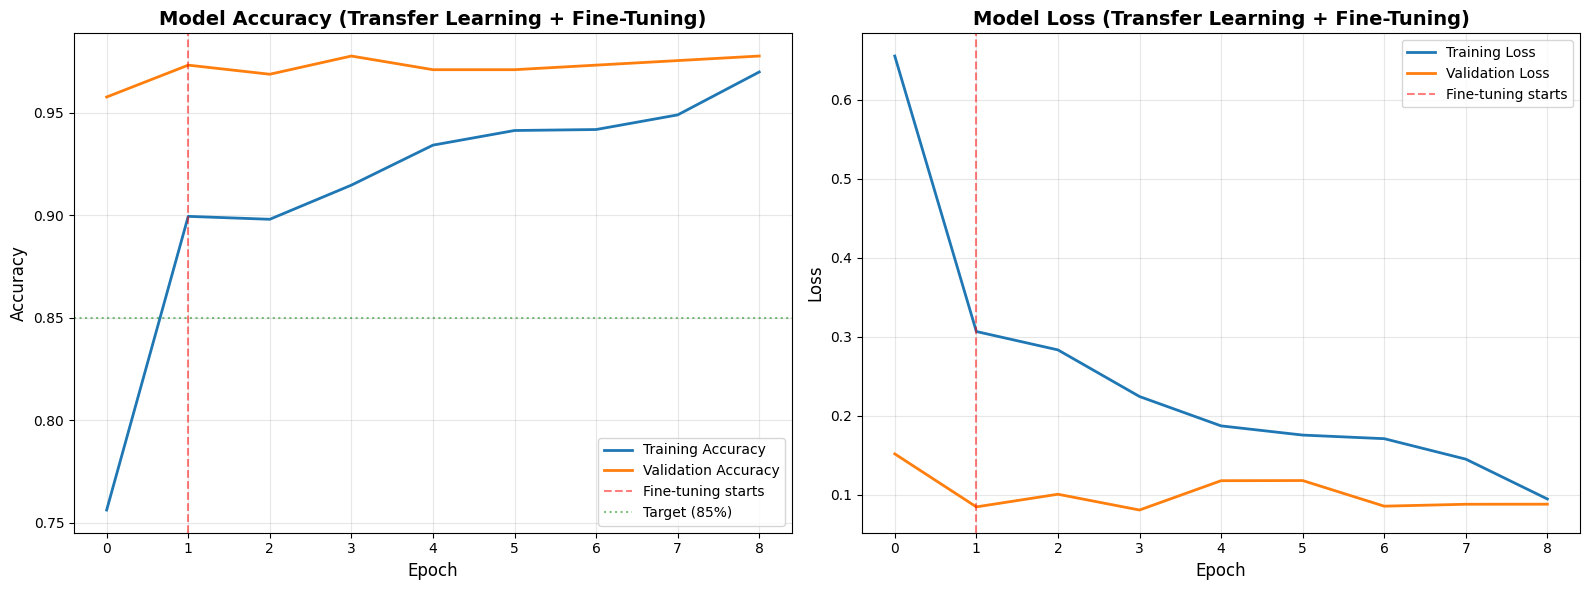

✓ Training history plot saved!

Training Summary:
  Phase 1 epochs: 2
  Phase 2 epochs: 7
  Total epochs: 9
  Best train accuracy: 97.00%
  Best val accuracy: 97.78%


In [36]:
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_phase1 = len(history_phase1.history['accuracy'])
epochs_total = len(combined_history['accuracy'])

# Plot Accuracy
ax1.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.axvline(x=epochs_phase1-1, color='red', linestyle='--', alpha=0.5, label='Fine-tuning starts')
ax1.axhline(y=0.85, color='green', linestyle=':', alpha=0.5, label='Target (85%)')
ax1.set_title('Model Accuracy (Transfer Learning + Fine-Tuning)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Plot Loss
ax2.plot(combined_history['loss'], label='Training Loss', linewidth=2)
ax2.plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
ax2.axvline(x=epochs_phase1-1, color='red', linestyle='--', alpha=0.5, label='Fine-tuning starts')
ax2.set_title('Model Loss (Transfer Learning + Fine-Tuning)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved!")

# Training summary
print("\nTraining Summary:")
print(f"  Phase 1 epochs: {epochs_phase1}")
print(f"  Phase 2 epochs: {epochs_total - epochs_phase1}")
print(f"  Total epochs: {epochs_total}")
print(f"  Best train accuracy: {max(combined_history['accuracy'])*100:.2f}%")
print(f"  Best val accuracy: {max(combined_history['val_accuracy'])*100:.2f}%")

In [37]:
print("="*60)
print("MENYIMPAN MODEL DALAM 3 FORMAT")
print("="*60)

# 1. SavedModel Format
saved_model_path = 'saved_model'
model.export(saved_model_path)
print(f"✓ [1/3] SavedModel: {saved_model_path}/")

# 2. TensorFlow Lite Format
tflite_dir = 'tflite'
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ [2/3] TF-Lite: {tflite_path}")

# Save labels
labels_path = os.path.join(tflite_dir, 'labels.txt')
with open(labels_path, 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")
print(f"         Labels: {labels_path}")

# 3. TensorFlow.js Format
print("\n[3/3] Converting to TensorFlow.js...")
try:
    import tensorflowjs as tfjs
    tfjs_dir = 'tfjs_model'
    tfjs.converters.save_keras_model(model, tfjs_dir)
    print(f"✓ TFJS: {tfjs_dir}/")
except ImportError:
    print("tensorflowjs not installed")

print("\n Semua format model berhasil disimpan!")
print("="*60)


MENYIMPAN MODEL DALAM 3 FORMAT
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_682')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137794296451472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296452624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296452432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296451856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296453200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296451280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296452816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296453008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296452048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137794296454160: TensorSpec(shape=(), dtype=tf.resourc

failed to lookup keras version from the file,
    this is likely a weight only file
✓ TFJS: tfjs_model/

 Semua format model berhasil disimpan!


INFERENCE - TESTING PREDICTIONS


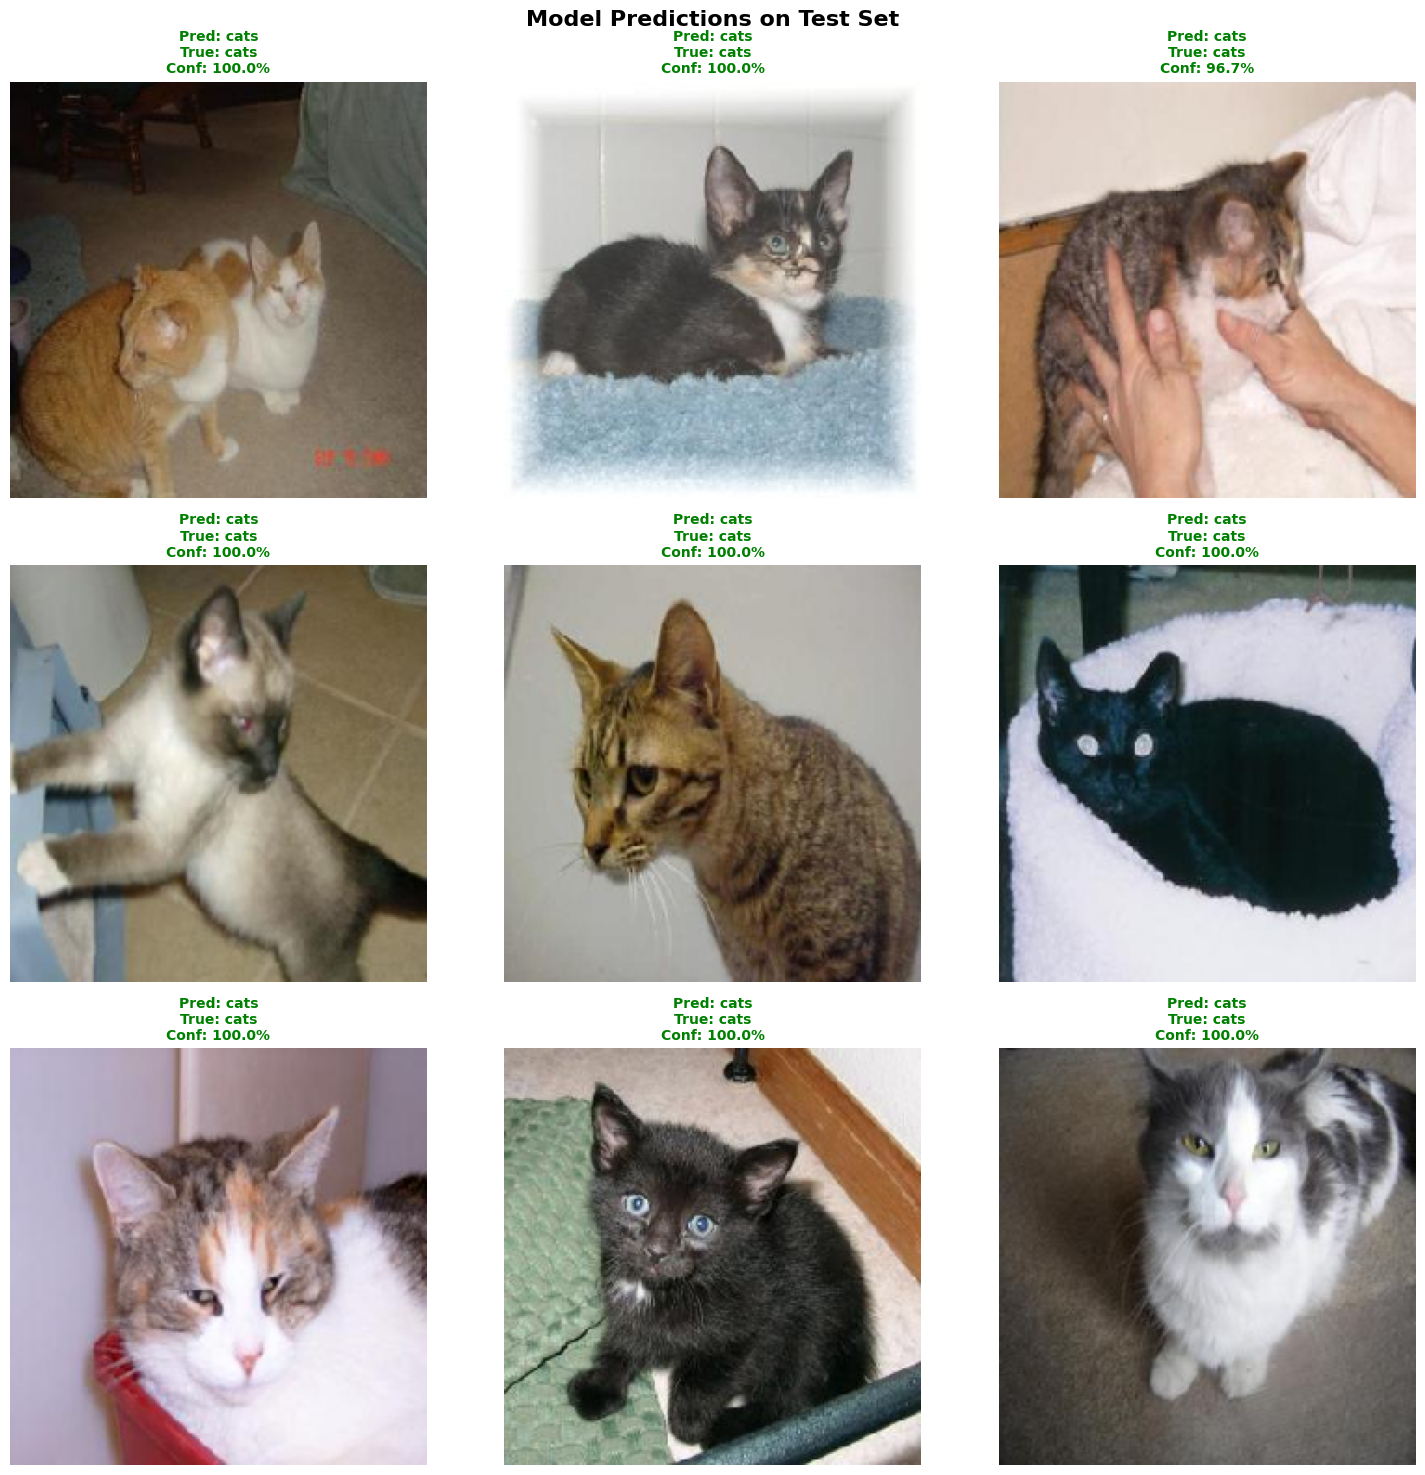

✓ Inference results saved to 'inference_results.png'
✓ Sample accuracy: 100.0% (9/9 correct)
TESTING TF-LITE MODEL
✓ TF-Lite Inference Successful!
  Input shape: [  1 224 224   3]
  Output shape: [1 3]

Prediction:
  Predicted Class: cats
  Confidence: 100.00%
  True Class: cats
  Result: ✅ CORRECT


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [38]:
print("="*60)
print("INFERENCE - TESTING PREDICTIONS")
print("="*60)

# Ambil sample dari test set
test_generator.reset()
test_images, test_labels = next(test_generator)

# Prediksi
predictions = model.predict(test_images[:9], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels[:9], axis=1)

# Visualisasi
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])

    pred_label = class_labels[predicted_classes[i]]
    true_label = class_labels[true_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100

    color = 'green' if pred_label == true_label else 'red'
    title = f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.1f}%"
    plt.title(title, color=color, fontweight='bold', fontsize=10)
    plt.axis('off')

plt.suptitle('Model Predictions on Test Set', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('inference_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Inference results saved to 'inference_results.png'")

# Hitung akurasi sample
correct = np.sum(predicted_classes == true_classes)
sample_accuracy = (correct / len(predicted_classes)) * 100
print(f"✓ Sample accuracy: {sample_accuracy:.1f}% ({correct}/{len(predicted_classes)} correct)")
print("="*60)

# %% [markdown]
# ## 📱 18. Test TF-Lite Model (Bukti Inference)

# %%
print("="*60)
print("TESTING TF-LITE MODEL")
print("="*60)

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test pada satu gambar
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])

tflite_class = np.argmax(tflite_pred)
tflite_confidence = tflite_pred[0][tflite_class] * 100

print(f"✓ TF-Lite Inference Successful!")
print(f"  Input shape: {input_details[0]['shape']}")
print(f"  Output shape: {output_details[0]['shape']}")
print(f"\nPrediction:")
print(f"  Predicted Class: {class_labels[tflite_class]}")
print(f"  Confidence: {tflite_confidence:.2f}%")
print(f"  True Class: {class_labels[true_classes[0]]}")

if tflite_class == true_classes[0]:
    print(f"  Result: ✅ CORRECT")
else:
    print(f"  Result: ❌ INCORRECT")

print("="*60)

CONFUSION MATRIX & DETAILED METRICS
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


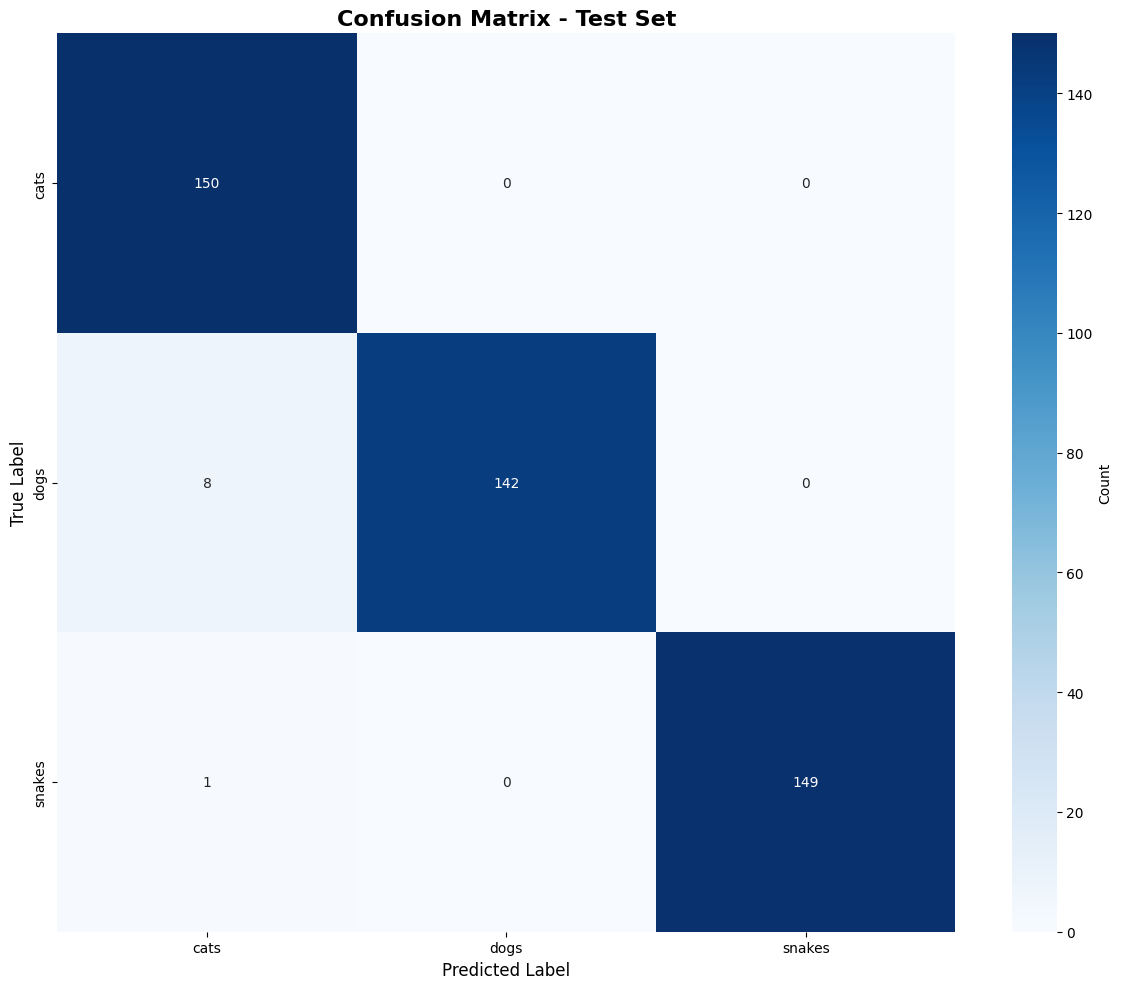

✓ Confusion matrix saved to 'confusion_matrix.png'

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        cats       0.94      1.00      0.97       150
        dogs       1.00      0.95      0.97       150
      snakes       1.00      0.99      1.00       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [39]:
print("="*60)
print("CONFUSION MATRIX & DETAILED METRICS")
print("="*60)

# Prediksi semua test data
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'confusion_matrix.png'")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
print("="*60)

In [41]:
import json

print("="*60)
print("METRICS SAVED")
print("="*60)

metrics = {
    "model_info": {
        "architecture": "Hybrid Model (Transfer Learning + Custom CNN)",
        "base_model": "MobileNetV2 (ImageNet)",
        "custom_layers": "3 Conv2D + 3 MaxPooling",
        "total_parameters": int(total_params)
    },
    "dataset": {
        "total_images": total_imgs,
        "num_classes": num_classes,
        "class_names": class_labels,
        "train_samples": train_generator.samples,
        "val_samples": validation_generator.samples,
        "test_samples": test_generator.samples,
        "imbalance_ratio": float(imbalance_ratio)
    },
    "training": {
        "phase1_epochs": epochs_phase1,
        "phase2_epochs": epochs_total - epochs_phase1,
        "total_epochs": epochs_total,
        "batch_size": BATCH_SIZE,
        "image_size": IMG_SIZE,
        "optimizer": "Adam",
        "phase1_lr": 0.001,
        "phase2_lr": 0.0001
    },
    "performance": {
        "train_accuracy": float(train_accuracy),
        "validation_accuracy": float(val_accuracy),
        "test_accuracy": float(test_accuracy),
        "train_loss": float(train_loss),
        "validation_loss": float(val_loss),
        "test_loss": float(test_loss)
    },
    "best_performance": {
        "best_train_accuracy": float(max(combined_history['accuracy'])),
        "best_val_accuracy": float(max(combined_history['val_accuracy']))
    },
    "callbacks": [
        "CustomAccuracyCallback",
        "EarlyStopping",
        "ModelCheckpoint",
        "ReduceLROnPlateau"
    ],
    "data_augmentation": {
        "rotation_range": 40,
        "width_shift_range": 0.3,
        "height_shift_range": 0.3,
        "shear_range": 0.3,
        "zoom_range": 0.3,
        "horizontal_flip": True,
        "brightness_range": [0.8, 1.2]
    }
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("="*60)
print("METRICS SAVED")
print("="*60)
print("✓ Training metrics saved to 'model_metrics.json'")
print("="*60)

METRICS SAVED
METRICS SAVED
✓ Training metrics saved to 'model_metrics.json'


In [43]:
with open("requirements.txt", "w") as f:
    f.write("""tensorflow==2.16.1
tensorflow-hub
tensorflowjs
numpy
pandas
matplotlib
seaborn
scikit-learn
Pillow
jupyter
opencv-python
""")
print("requirements.txt created successfully!")


requirements.txt created successfully!


In [45]:
!ls



best_model_phase1.keras  inference_results.png	saved_model
best_model_phase2.keras  model_metrics.json	tfjs_model
confusion_matrix.png	 requirements.txt	tflite
dataset_split		 sample_data		training_history.png
drive			 sample_images.png


In [47]:
!zip -r /content/project_results.zip \
best_model_phase1.keras \
best_model_phase2.keras \
confusion_matrix.png \
inference_results.png \
model_metrics.json \
requirements.txt \
sample_images.png \
training_history.png \
dataset_split \
saved_model \
tfjs_model \
tflite


  adding: best_model_phase1.keras (deflated 10%)
  adding: best_model_phase2.keras (deflated 10%)
  adding: confusion_matrix.png (deflated 29%)
  adding: inference_results.png (deflated 0%)
  adding: model_metrics.json (deflated 55%)
  adding: requirements.txt (deflated 21%)
  adding: sample_images.png (deflated 0%)
  adding: training_history.png (deflated 12%)
  adding: dataset_split/ (stored 0%)
  adding: dataset_split/validation/ (stored 0%)
  adding: dataset_split/validation/snakes/ (stored 0%)
  adding: dataset_split/validation/snakes/2_0352.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0912.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0401.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0940.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0738.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0637.jpg (deflated 1%)
  adding: dataset_split/validation/snakes/2_0904.jpg (deflated 1%)
  adding: dataset_split/val

In [48]:
from google.colab import files
files.download("/content/project_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>